*Aprenentatge Computacional*  
- Zakaria Boudich Makran (1672001)

# Pràctica - Google Play Store Apps

En aquesta pràctica s'abordarà la creació d'un model per tal de predir el nombre de descàrregues que tindrà una aplicació mòbil, representat per l'atribut *installs*. Seguirem una sèrie de passos per obtenir el resultat, primer analitzarem les dades, les preprocessarem, s'escollirà les mètriques i els diferents models per així aconseguir el millor classificador.

## 0. Importació de llibreries 

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades ⚙️

In [775]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# FUNCIÓ QUE ENS PERMET DIVIDIR EN DOS CONJUNTS EL DATASET 
from sklearn.model_selection import train_test_split

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
from category_encoders.one_hot import OneHotEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

# LLIBRERIA PER GESTIONAR I MANIPULAR DATES I HORES 
from datetime import datetime

# LlIBRERIA QUE ENS PERMET TREBALLAR AMB EXPRESSIONS REGULARS
import re

import warnings

# Suprimir todos los warnings
warnings.filterwarnings('ignore')

## 1. EDA (exploratory data analysis) 

En aquest apartat, realitzarem una anàlisi exploratòria de les dades, on examinarem les característiques del conjunt de dades, buscarem patrons i visualitzarem la distribució de les variables. 

En aquest cas, ens ve donat **dos conjunts de dades**. L'objectiu serà unir-los per aprofitar els atributs més rellevants de cadascun i utilitzar-los en l'entrenament del model. Ara farem una breu descripció de cada conjunt de dades:

**1. Dataset de les aplicacions (Apps):** 📲  
* Conté informació sobre les aplicacions a la Google Play Store, com el nom, la categoria, la valoració mitjana, el nombre d'instal·lacions, el preu, etc.  
* Aquest conjunt de dades ens permet entendre les característiques bàsiques de cada aplicació i el seu rendiment a la botiga.

**2. Dataset de les ressenyes (Reviews):** ⭐ 
* Conté les opinions dels usuaris sobre les aplicacions anteriors. Cada ressenya inclou la valoració que l'usuari ha donat a l'aplicació, comentari de l'usuari, etc. 
* Aquest conjunt de dades és útil per estudiar el sentiment dels usuaris i com les valoracions individuals poden influir en la valoració general de l'aplicació.

**Per simplicitat**, primer tractarem el dataset d'aplicacions i després el de les ressenyes.


### 1.1. Anàlisis del dataset de les aplicacions

#### 1.1.1. Descripció dels atributs


In [776]:
apps_data = pd.read_csv("data/aplicacions.csv")
apps_train_data, apps_test_data = train_test_split(apps_data, test_size=0.2, random_state=42)
apps_train_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
6762,Black Social,SOCIAL,4.6,22,8.7M,"1,000+",Free,0,Teen,Social,"August 5, 2018",31.1.4,4.3 and up
401,Google Allo,COMMUNICATION,4.3,346982,Varies with device,"10,000,000+",Free,0,Everyone,Communication,"January 23, 2018",Varies with device,4.1 and up
7420,CJ Camcorder,VIDEO_PLAYERS,4.7,3,2.8M,500+,Free,0,Everyone,Video Players & Editors,"November 26, 2017",1.0,4.0 and up
1631,Scarf Fashion Designer,LIFESTYLE,4.4,16637,10M,"1,000,000+",Free,0,Everyone,Lifestyle,"June 18, 2017",1.8,2.3 and up
6475,iFORA BM,MEDICAL,NaN,3,10M,100+,Free,0,Everyone,Medical,"April 9, 2018",1.0.8,4.3 and up


In [777]:
print("El nombre de mostres que tenim a la base de dades és de", apps_train_data.shape[0])
print("El nombre de atributs que tenim a la base de dades és de", apps_train_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 8672
El nombre de atributs que tenim a la base de dades és de 13


Es pot veure que disposem de 13 atributs diferents amb un total de 10841 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del nombre de descàrregues d'una aplicació.


In [778]:
print("Informació de cada atribut:")
print(apps_train_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
Index: 8672 entries, 6762 to 7270
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8672 non-null   object 
 1   Category        8672 non-null   object 
 2   Rating          7495 non-null   float64
 3   Reviews         8672 non-null   object 
 4   Size            8672 non-null   object 
 5   Installs        8672 non-null   object 
 6   Type            8671 non-null   object 
 7   Price           8672 non-null   object 
 8   Content Rating  8671 non-null   object 
 9   Genres          8672 non-null   object 
 10  Last Updated    8672 non-null   object 
 11  Current Ver     8665 non-null   object 
 12  Android Ver     8669 non-null   object 
dtypes: float64(1), object(12)
memory usage: 948.5+ KB
None


La base de dades conté 13 atributs on es descriu les característiques de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació.  
- **Category (Objecte):** Categoria de l'aplicació.  
- **Rating (Float64):** Valoració mitjana de l'aplicació (valor de 1 a 5).  
- **Reviews (Objecte):** Nombre de ressenyes que té l'aplicació. 
- **Size (Objecte):** Mida de l'aplicació en megabytes (Pot incloure unitats com 'M' o 'k'). Si la mida depèn del dispositiu s'utilitza l'expressió "Varies with devices".
- **Installs (Objecte):** Nombre d'instal·lacions de l'aplicació. (Inclou el caràcter +)
- **Type (Objecte):** Si l'aplicació és gratuïta o de pagament.  
- **Price (Objecte):** El preu de l'aplicació (si és de pagament). S'inclou el símbol '$', indicant que el preu esta en dòlars. 
- **Content Rating (Objecte):** Classificació per contingut (per exemple, "Tots els públics", "Adolescents", etc.).  
- **Genres (Objecte):** Gèneres de l'aplicació (com "Acció", "Educació", etc.).  
- **Last Updated (Objecte):** La data de l'última actualització de l'aplicació indica quan es va modificar per última vegada. Es presenta en el format "MMMM DD, YYYY".
- **Current Ver (Objecte):** Versió actual de l'aplicació.  
- **Android Ver (Objecte):** Versió d'Android compatible amb l'aplicació.



#### 1.1.2. Detecció de valors nuls

A continuació mostrarem el nombre de NaNs per cada atribut:


In [779]:
print(apps_train_data.isnull().sum()[apps_train_data.isnull().sum() > 0])

Rating            1177
Type                 1
Content Rating       1
Current Ver          7
Android Ver          3
dtype: int64


Podem observar la aparició de valors nuls en els atributs següents: *Rating*, *Current Ver*, *Android Ver* i *Type*. D'aquests atributs el més significatiu és el *Rating*, obtenint un percentatge de NaNs proper el 15%.\
A continuació, el que farem és imprimir algunes files del dataset on el *Rating* tingui un valor NaN, per veure si mitjançant els altres atributs, podem determinar si els valors nuls del atribut *Rating* tenen algun significat o son a causa d'algun error. 

In [780]:
null_ratings = apps_train_data[apps_train_data['Rating'].isnull()]
print(null_ratings.head().to_string(index=False))

                       App        Category  Rating Reviews Size Installs Type Price Content Rating          Genres    Last Updated Current Ver Android Ver
                  iFORA BM         MEDICAL     NaN       3  10M     100+ Free     0       Everyone         Medical   April 9, 2018       1.0.8  4.3 and up
               EH Autolink        BUSINESS     NaN       1 921k     100+ Free     0       Everyone        Business  March 11, 2016         1.0  3.0 and up
Top Themes Volvo FH Trucks PERSONALIZATION     NaN       9  18M   1,000+ Free     0           Teen Personalization   June 19, 2018         1.0  4.1 and up
   AX Watch for WatchMaker PERSONALIZATION     NaN       2 238k       1+ Paid $0.99       Everyone Personalization August 18, 2017         1.0  2.3 and up
            Valmet CI Tool        BUSINESS     NaN       1 3.7M     500+ Free     0       Everyone        Business  March 13, 2018       0.0.6  4.0 and up


Com es pot veure, tot indica que els valors nuls de l'atribut *Rating* son errors a la hora de crear el dataset o per una altre raó que desconeixem, ja que les aplicacions que és mostren, el nombre de ressenyes (*reviews*) és major a zero, però tot i així apareix un valor nul en l'atribut *Rating*. 

#### 1.1.3. Detecció de dades anomals

En aquest apartat, comprovarem que alguns atributs del dataset no continguin valors anòmals (outliers) no detectats inicialment, considerant-ne els resultats principalment pel *preprocessing* dels atributs. S'ha de tenir en compte que no considerarem els valors nuls com a valors anomals, ja que els hem tractat anteriorment.\
Començarem verificant els atributs que considera la llibreria Pandas com a numèrics, i posteriorment passarem als categòrics. 

**1. Atributs numèrics: 🔢** 
- **Rating:** Verifiquem que no tinguem valors negatius o valors fora del rang [1, 5].

In [781]:
print(f"Rating - Min: {apps_train_data['Rating'].min()}, Max: {apps_train_data['Rating'].max()}")

Rating - Min: 1.0, Max: 19.0


Com podem veure, tot i que no tenim valors negatius, ens aparèix un valor fora del rang [1,5]. Per entrar en l'arrel del problema, visualitzarem les files que contenen valors majors a 5 en l'atribut:

In [782]:
incorrect_ratings = apps_train_data[apps_train_data['Rating'] > 5]
print(incorrect_ratings.to_string(index=False))

                                    App Category  Rating Reviews   Size Installs Type    Price Content Rating            Genres Last Updated Current Ver Android Ver
Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M 1,000+     Free    0 Everyone            NaN February 11, 2018       1.0.19  4.0 and up         NaN


La sortida anterior, ens indica que hi ha una fila on els valors dels atributs no estan correctament assignats. Per exemple, veiem que el nombre de descargues de l'aplicació, que en aquest cas és 1000, no està inserit en l'atribut *Installs* (que és on hauria d'estar), sino en l'atribut *Size*. Amb altres atributs d'aquesta fila ens passa el mateix. Com a cas especial, per no veure el mateix error en les comprovacions següents, corregirem manualment aquesta fila:

In [783]:
apps_train_data.loc[10472] = ['Life Made Wi-Fi Touchscreen Photo Frame', 'PHOTOGRAPHY', 1.9, 19.0, '3.0MB', '1,000+', 'Free', 0, 'Everyone', 'Photography', 'February 11, 2018', '1.0.19', '4.0 and up']

**2. Atributs categòrics: 🏷️** 

- **Last Updated**: Com a verificació, ens assegurarem que les dates segueixin un patró de format bàsic. En aquest cas, que el primer element sigui una paraula per al mes, seguit d’un número per al dia (de 1 o 2 dígits), i un any de quatre dígits. Per aconseguir-ho, ens ajudarem de les expresions regulars. En la sortida imprimirem les dates que no siguin vàlides.

In [784]:
date_pattern = r"^[A-Za-z]+ \d{1,2}, \d{4}$"
invalid_dates = apps_train_data[~apps_train_data["Last Updated"].str.match(date_pattern, na=False)]
print(invalid_dates["Last Updated"])

Series([], Name: Last Updated, dtype: object)


Com que la llista és buida, podem dir que les dates contenides en l'atribut tenen un format bàsic vàlid. 

- **Reviews**, **Installs**, **Price**: Tot i que Pandas ha assignat aquests atributs com a categòrics, per la seva naturaleza els podem considerar com a numèrics. Com s'ha fet per l'atribut *Rating*, agafarem el valor mínim de cada atribut per detectar si tenim valors negatius. Com a casos especials, per a trobar el mínim de l'atribut *Installs* i *Price*, abans haurem d'eliminar algun caràcter present en els seus valors. Per exemple, en l'atribut *Price* ens hi pot aparèixer el caràcter "$".

In [785]:
# Convertim "Reviews" a numèric sense modificar el dataframe original
reviews_summary = pd.to_numeric(apps_train_data["Reviews"], errors='coerce').describe()
print(f"Reviews - Min: {reviews_summary['min']}")

# Eliminem el caràcter "+" dels valors de "Installs" sense modificar l'original
installs_cleaned = apps_train_data["Installs"].str.replace('+', '', regex=False)
installs_summary = pd.to_numeric(installs_cleaned, errors='coerce').describe()
print(f"Installs - Min: {installs_summary['min']}")

# Eliminem el caràcter "$" dels valors de "Price" sense modificar l'original
price_cleaned = apps_train_data["Price"].str.replace('$', '', regex=False)
price_summary = pd.to_numeric(price_cleaned, errors='coerce').describe()
print(f"Price - Min: {price_summary['min']}")

Reviews - Min: 0.0
Installs - Min: 0.0
Price - Min: 0.0


Com que el valor mínim per cada atribut és 0, podem dir que no hi tenim valors negatius. 

- **Type**, **Content Rating**, **Category**, **Genres**: Realitzarem una revisió manual per assegurar-nos que hi hagi categories coherents per a cada atribut.

In [786]:
print("Type")
print(apps_train_data["Type"].unique())
print()

print("Content Rating")
print(apps_train_data["Content Rating"].unique())
print()

print("Category")
print(apps_train_data["Category"].unique())
print()

print("Genres")
print(apps_train_data["Genres"].unique())
print()

Type
['Free' 'Paid' nan]

Content Rating
['Teen' 'Everyone' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated']

Category
['SOCIAL' 'COMMUNICATION' 'VIDEO_PLAYERS' 'LIFESTYLE' 'MEDICAL' 'BUSINESS'
 'GAME' 'FAMILY' 'PERSONALIZATION' 'HOUSE_AND_HOME' 'TRAVEL_AND_LOCAL'
 'TOOLS' 'NEWS_AND_MAGAZINES' 'WEATHER' 'HEALTH_AND_FITNESS' 'EDUCATION'
 'PRODUCTIVITY' 'PHOTOGRAPHY' 'BEAUTY' 'SPORTS' 'SHOPPING' 'EVENTS'
 'PARENTING' 'DATING' 'BOOKS_AND_REFERENCE' 'FINANCE'
 'MAPS_AND_NAVIGATION' 'ENTERTAINMENT' 'LIBRARIES_AND_DEMO'
 'FOOD_AND_DRINK' 'ART_AND_DESIGN' 'COMICS' 'AUTO_AND_VEHICLES']

Genres
['Social' 'Communication' 'Video Players & Editors' 'Lifestyle' 'Medical'
 'Business' 'Music' 'Adventure' 'Entertainment' 'Personalization' 'Action'
 'House & Home' 'Educational;Brain Games' 'Travel & Local' 'Tools'
 'News & Magazines' 'Weather' 'Health & Fitness' 'Education'
 'Simulation;Action & Adventure' 'Puzzle' 'Productivity' 'Casual'
 'Photography' 'Beauty' 'Sports' 'Shopping' 'Board;Brain

Segons la sortida anterior podem veure que tenim categories coherents amb la temàtica del dataset.

#### 1.1.4. Correlació d'atributs


### 1.2. Anàlisis del dataset de les ressenyes

#### 1.2.1. Descripció dels atributs

In [787]:
reviews_data = pd.read_csv("data/ressenyes.csv")
reviews_train_data, reviews_test_data = train_test_split(reviews_data, test_size=0.2, random_state=42)
reviews_train_data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
60632,Health and Nutrition Guide,The facts correct I'm seeing anything except f...,Neutral,0.0,0.0
40286,Entel,I would like to know where I can redeem my ent...,Neutral,0.0,0.0
50243,Fruit Boom,NaN,NaN,NaN,NaN
46991,Flights,Poser- I mislead thinking Google Flights app. ...,Neutral,0.0,0.0
14217,Best New Ringtones 2018 Free 🔥 For Android™,NaN,NaN,NaN,NaN


In [788]:
print("El nombre de mostres que tenim a la base de dades és de", reviews_train_data.shape[0])
print("El nombre de atributs que tenim a la base de dades és de", reviews_train_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 51436
El nombre de atributs que tenim a la base de dades és de 5


Es pot veure que disposem de 5 atributs diferents amb un total de 64295 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del nombre de descàrregues d'una aplicació.


In [789]:
print("Informació de cada atribut:")
print(reviews_train_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
Index: 51436 entries, 60632 to 56422
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     51436 non-null  object 
 1   Translated_Review       29925 non-null  object 
 2   Sentiment               29929 non-null  object 
 3   Sentiment_Polarity      29929 non-null  float64
 4   Sentiment_Subjectivity  29929 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.4+ MB
None


El conjunt de dades conté 5 atributs on es descriu les característiques de reviews de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació a la qual pertany la ressenya. Ens serveix com enllaç del dataset anterior. 
- **Translated_Review (Objecte):** Comentari de l'usuari de l'aplicació traduït a l'anglès. Pot contenir valors nuls si no hi ha comentari. 
- **Sentiment (Objecte):** Categoria del sentiment expressat en el comentari de l'usuari (per exemple, "Positiu", "Negatiu" o "Neutral").  
- **Sentiment_Polarity (Float64):** Mesura de polaritat del sentiment del comentari de l'usuari, amb valors entre -1 (molt negatiu) i 1 (molt positiu).  
- **Sentiment_Subjectivity (Float64):** Mesura de subjectivitat del comentari de l'usuari, amb valors entre 0 (totalment objectiu) i 1 (totalment subjectiu). 

#### 1.2.2. Detecció de valors nuls

Segons la sortida anterior podem veura una gran quantitat de valors nuls en les característiques, excepte l'atribut *App*. Anem a veure la distribució per cada atribut:

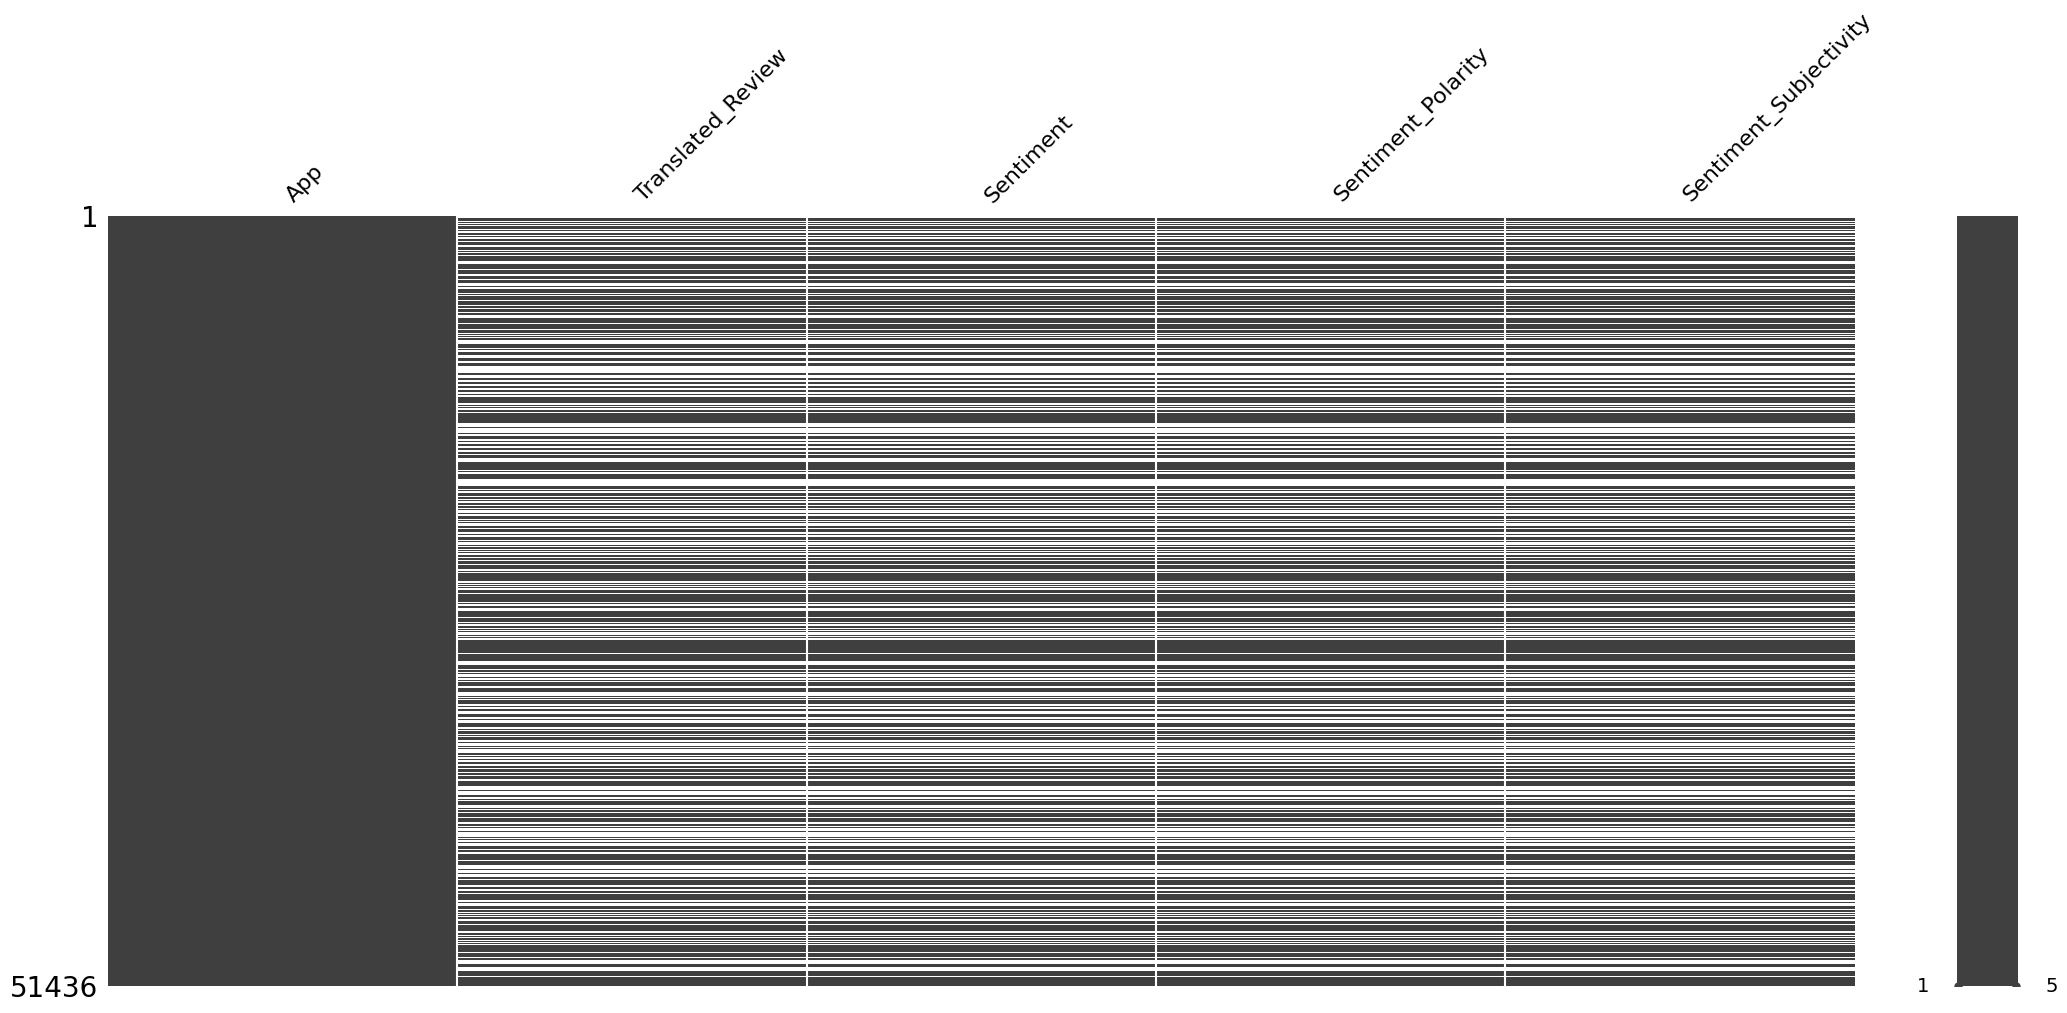

In [790]:
msno.matrix(reviews_train_data)
plt.show()

Com podem observar, hi ha una forta dependència entre els atributs *Translated_Review*, *Sentiment*, *Sentiment_Polarity* i *Sentiment_Subjectivity* pel que fa als valors nuls. Entenem que la causa de tot això és l'atribut *Translated_Review*, ja que l'ànalisi del sentiment requereix que l'usuari hagi escrit un text per a la seva ressenya. Podem concloure, que els valors nuls en aquest cas tenen un significat concret.

Per entrar més en detall, crearem un gràfic que mostri el percentatge de valors nuls en els comentaris de cada aplicació, en funció del nombre total de comentaris de cada una.

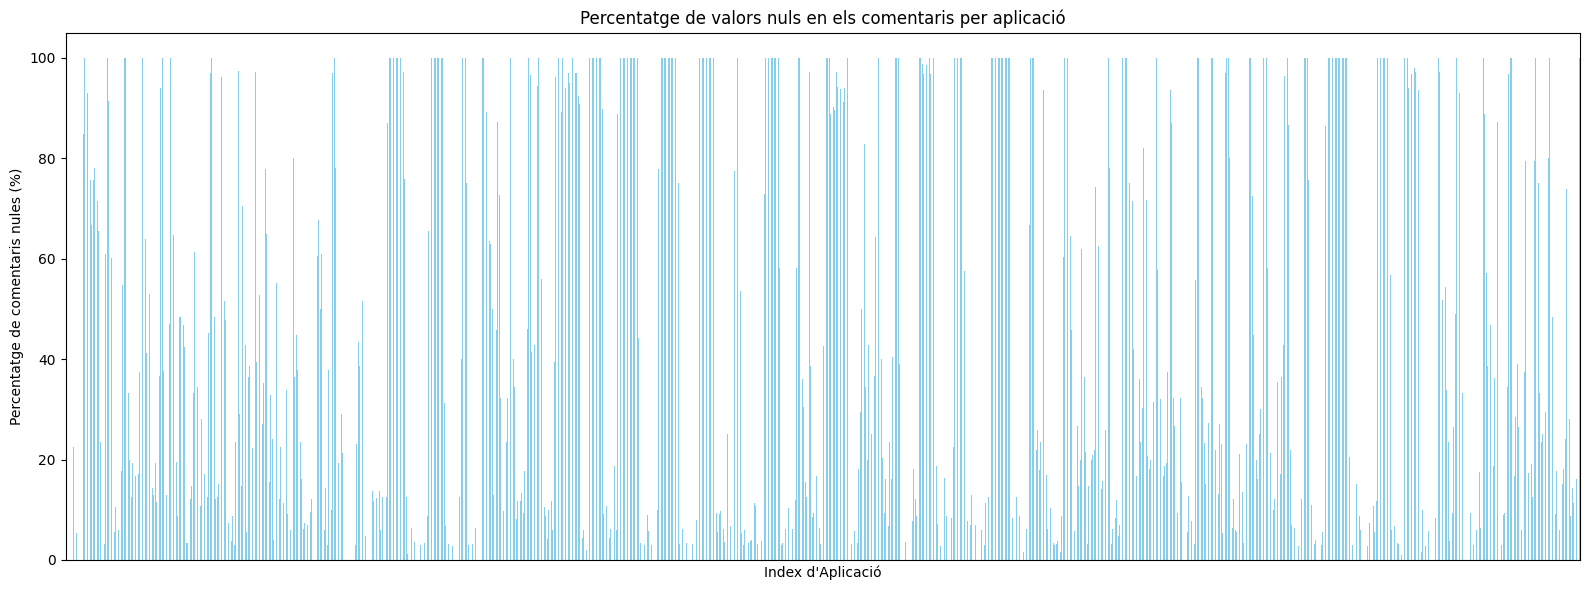

In [791]:
grouped_data = reviews_train_data.groupby('App')
nans_in_reviews = grouped_data['Translated_Review'].agg(lambda x: x.isna().sum())
total_reviews = grouped_data['Translated_Review'].count() + nans_in_reviews
nan_percentage = (nans_in_reviews / total_reviews) * 100

plt.figure(figsize=(16, 6)) 
nan_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentatge de valors nuls en els comentaris per aplicació')
plt.xlabel('Index d\'Aplicació')
plt.ylabel('Percentatge de comentaris nules (%)')
plt.xticks([])  

plt.subplots_adjust(left=0.05, right=0.95) 
plt.tight_layout()
plt.show()

Segons el gràfic, podem observar que una gran majoria d'aplicacions no contenen comentaris. Per quantificar-ho millor, a continuació calcularem el percentatge d'aplicacions que no contenen comentaris segons el total d'aplicacions en el dataset *reviews*:

In [792]:
aplicacions_sense_resenyes = (nan_percentage == 100).sum()
total_aplicacions = len(nan_percentage)
percentatge_sense_resenyes = (aplicacions_sense_resenyes / total_aplicacions) * 100
percentatge_sense_resenyes = round(percentatge_sense_resenyes, 2)
print(f'Percentatge d\'aplicacions sense ressenyes: {percentatge_sense_resenyes}%')

Percentatge d'aplicacions sense ressenyes: 20.02%


Segons el càlcul anterior, el 19% d'aplicacions no contenen comentaris.

#### 1.2.3. Detecció de dades anomals

Com en el dataset *apps* comprovarem que els atributs no tinguin valors anòmals (*outliers*) que no hàgim detectat a primera vista. Començarem verificant els atributs categòrics, i posteriorment passarem als numèrics.  

**1. Atributs categòrics: 🏷️** 

- **App:** Comprovarem que tot nom d'aplicació del dataset *reviews* estigui present en el conjunt de dades *apps*. En percentatge expressarem el nombre d'aplicacions del dataset *reviews* que no estiguin present en el dataset *apps*. 

In [793]:
apps_set = set(apps_train_data['App'])
reviews_set = set(reviews_train_data['App'])
missing_apps = apps_set - reviews_set
missing_apps_count = len(missing_apps)
print(f"{(missing_apps_count / len(apps_set)) * 100:.2f}%")


88.97%


Segons el resultat anterior, podem veure que hi han aplicacions en el dataset *ressenyes* que no estan contingudes en el dataset *apps*, concretament un 89%.


- **Sentiment:** Verificarem que no tinguem una categoria anomala, o una categoria que no s'hagi contemplat a primera vista.

In [794]:
sentiment_counts = reviews_train_data['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
Positive    19267
Negative     6581
Neutral      4081
Name: count, dtype: int64


En aquest cas tenim les categories Positive, Negative i Neutral. No s'observa ningun cas extrany. 

**1. Atributs numèrics: 🔢** 
- **Sentiment_Polarity, Sentiment_Subjectivity:** Verificarem que no tinguem presents valors fora de rang dels respectius atributs. 

In [795]:
polarity_summary = reviews_train_data['Sentiment_Polarity'].describe()
subjectivity_summary = reviews_train_data['Sentiment_Subjectivity'].describe()

print(f"Sentiment_Polarity - Min: {polarity_summary['min']}, Max: {polarity_summary['max']}")
print(f"Sentiment_Subjectivity - Min: {subjectivity_summary['min']}, Max: {subjectivity_summary['max']}")

Sentiment_Polarity - Min: -1.0, Max: 1.0
Sentiment_Subjectivity - Min: 0.0, Max: 1.0


Podem comprovar pels dos atributs, que no ens apareix ningun valor fora de rang

#### 1.2.4. Correlació d'atributs

En aquesta secció, veurem com de correlacionats estan els atributs numèrics del dataset *reviews* amb relació al atribut objectiu, com s'ha dit, el nombre de descargues d'una aplicació. Per aconseguir-ho, calcularem la mitjana del *Sentiment_Polarity* i el *Sentiment_Subjectivity* per cada aplicació.

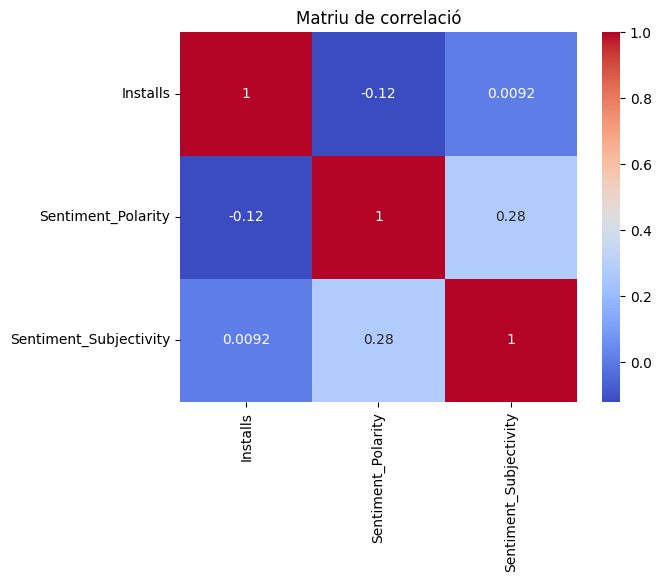

In [796]:
apps_train_data_temp = apps_train_data[['App', 'Installs']].copy()
apps_train_data_temp['Installs'] = apps_train_data_temp['Installs'].replace({',': '', r'\+': ''}, regex=True).astype(int)

reviews_train_data = reviews_train_data.dropna(subset=['Sentiment_Polarity', 'Sentiment_Subjectivity'])

reviews_grouped = reviews_train_data.groupby('App', as_index=False).agg({
    'Sentiment_Polarity': 'mean',
    'Sentiment_Subjectivity': 'mean'
})

merged_data = pd.merge(apps_train_data_temp, reviews_grouped, on='App', how='inner')

corr_matrix = merged_data.drop(columns=['App']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriu de correlació')
plt.show()


Podem veure que l'atribut *Sentiment_Subjectivity* no té practicament ninguna correlació amb el nombre de descargues. En canvi, per l'atribut *Sentiment_Polarity* té una correlació més alta, concretament del 27%. 

## 2. Preprocessing 

En aquest apartat, es duran a terme tres etapes per preparar els atributs: tractament dels valors nuls, codificació de les variables categòriques i normalització dels valors numèrics. A més, crearem nous atributs que milloraran la capacitat del model per identificar patrons. 

Cal dir que, el dataset *reviews* es descartarà de bon principi per entrenar el model, ja que presenta diverses limitacions importants. En primer lloc, podem veure que el dataset *reviews* només inclou el 10% de les aplicacions que estan presents al dataset *apps*, com s'ha vist en l'apartat de detecció d'anomalies. A més, hem vist que els atributs que conté el dataset *reviews* pràcticament no tenen correlació amb l'atribut objectiu. Això provoca que la utilització del dataset *reviews* sigui inviable per entrenar el model.

### 2.1. Tractament de valors nuls

En aquest apartat, tractarem els valors nuls que ens apareixen en el dataset *apps*. Com s'ha vist en la detecció de valors nuls, ens apareixen valors nuls principalment en l'atribut *Rating*, seguidament dels atributs *Current Ver*, *Android Ver* i *Type*. Com a recordatori, a continuació s'imprimeix el nombre de valors nuls dels atributs esmentats:

In [797]:
nan_counts = apps_train_data.isnull().sum()
nan_columns = nan_counts[nan_counts > 0]
sorted_nulls = nan_columns.sort_values(ascending=False)
print(sorted_nulls)

Rating         1177
Current Ver       7
Android Ver       2
Type              1
dtype: int64


Ara tractarem els valors numèrics, en aquest cas l'únic que tenim és l'atribut *Rating*, i a continuació els atributs de tipus categòric. 
Per inserir els valors nuls, podem optar per aplicar la mitjana o la mediana de les dades, depenent de la variança de les dades. Sabem que, en atributs amb una alta variació, la mitjana no ens pot donar un valor representatiu de les dades. Per quantificar aquesta variabilitat, farem servir el coeficient de variació. Si el coeficient és alt, els valors nuls s'inseriran aplicant la mediana. En cas contrari, si el coeficient és baix, els valors nuls s'inseriran aplicant la mitjana. Seguint la convenció, considerarem que un coeficient de variació major al 20% indica que la variació de les dades és alta. 

In [798]:
mean_rating = apps_train_data['Rating'].mean()
std_rating = apps_train_data['Rating'].std()
cv_rating = (std_rating / mean_rating) * 100
print("Coeficient de variació de l'atribut Rating:", cv_rating)

Coeficient de variació de l'atribut Rating: 12.386324998050604


Com veiem, la variació es pot considerar baixa, concretament un 11%. Per aquesta raó, a continuació emplenarem els valors nuls de l'atribut *Rating* utilitzant la mitjana:

In [799]:
# Calcular la mitjana de l'atribut Rating
mean_rating = apps_train_data['Rating'].mean()

# Emplenem els valors nuls del test i el train amb la mitjana calculada anteriorment 
apps_train_data['Rating'] = apps_train_data['Rating'].fillna(mean_rating)
apps_test_data['Rating'] = apps_test_data['Rating'].fillna(mean_rating)

Pels atributs categòrics, els valors nuls els emplenarem amb la categoria més freqüent de la columna, és a dir, utilitzant la moda.

In [800]:
# Omplir els valors nuls a 'Current Ver', 'Android Ver' i 'Type' del conjunt d'entrenament
apps_train_data['Current Ver'] = apps_train_data['Current Ver'].fillna(apps_train_data['Current Ver'].mode()[0])
apps_train_data['Android Ver'] = apps_train_data['Android Ver'].fillna(apps_train_data['Android Ver'].mode()[0])
apps_train_data['Type'] = apps_train_data['Type'].fillna(apps_train_data['Type'].mode()[0])

# Omplir els valors nuls a 'Current Ver', 'Android Ver' i 'Type' del conjunt de prova
apps_test_data['Current Ver'] = apps_test_data['Current Ver'].fillna(apps_train_data['Current Ver'].mode()[0])
apps_test_data['Android Ver'] = apps_test_data['Android Ver'].fillna(apps_train_data['Android Ver'].mode()[0])
apps_test_data['Type'] = apps_test_data['Type'].fillna(apps_train_data['Type'].mode()[0])

### 2.2. Codificació i Normalització d'atributs

Un cop finalitzat el tractament dels valors nuls, aquesta secció se centrarà en la codificació de les variables categòriques del conjunt train i test alhora. Aquest pas és essencial, ja que algorismes com el Support Vector Regression o el regressió lineal, que s'utilitzaran més endavant, requereixen que totes les dades estiguin codificades en format numèric per funcionar correctament.

Com a recordatori, del dataset *apps* tenim els següents atributs categòrics: 

- **App**  
- **Category**  
- **Reviews** 
- **Size** 
- **Installs** 
- **Type** 
- **Price** 
- **Content Rating** 
- **Genres** 
- **Last Updated** 
- **Current Ver** 
- **Android Ver** - Per fer

Com a primers atributs, tractarem la columna *Reviews*, *Installs* i *Price*. Com a casos especials, no caldrà codificar aquest atributs. Com s'ha comentat en una secció anterior, son atributs essencialment numèrics, tot i que Pandas els ha assignat com a categòrics. El que farem en aquest cas, pels atributs *Installs* i *Price*, serà eliminar algun caràcter present en els seus valors, i en el tres atributs caldrà convertir-los a tipus numèric.

In [801]:
# Atribut Reviews
apps_train_data["Reviews"] = pd.to_numeric(apps_train_data["Reviews"], errors='coerce')
apps_test_data["Reviews"] = pd.to_numeric(apps_test_data["Reviews"], errors='coerce')

# Atribut Installs
installs_cleaned_train = apps_train_data["Installs"].str.replace('+', '', regex=False)
apps_train_data["Installs"] = pd.to_numeric(installs_cleaned_train, errors='coerce')

installs_cleaned_test = apps_test_data["Installs"].str.replace('+', '', regex=False)
apps_test_data["Installs"] = pd.to_numeric(installs_cleaned_test, errors='coerce')

# Atribut Price
price_cleaned_train = apps_train_data["Price"].str.replace('$', '', regex=False)
apps_train_data["Price"] = pd.to_numeric(price_cleaned_train, errors='coerce')

price_cleaned_test = apps_test_data["Price"].str.replace('$', '', regex=False)
apps_test_data["Price"] = pd.to_numeric(price_cleaned_test, errors='coerce')

Continuarem codificant els següents atributs categòrics *Type*, *Content Rating*, *Genres* i *Category*. En aquest cas, utilitzarem el One-Hot Encoding, ja que son atributs que no tenen un ordre en quant el seus valors, la qual cosa fa que altres tècniques com el Label Encoding no siguin apropiades

In [802]:
# atribut Type
onehot_encoder = OneHotEncoder(cols=['Type'], use_cat_names=True)
apps_train_data = onehot_encoder.fit_transform(apps_train_data)
apps_test_data = onehot_encoder.transform(apps_test_data)

# atribut Content Rating
onehot_encoder = OneHotEncoder(cols=['Content Rating'], use_cat_names=True)
apps_train_data = onehot_encoder.fit_transform(apps_train_data)
apps_test_data = onehot_encoder.transform(apps_test_data)

# atribut Genres
onehot_encoder = OneHotEncoder(cols=['Genres'], use_cat_names=True)
apps_train_data = onehot_encoder.fit_transform(apps_train_data)
apps_test_data = onehot_encoder.transform(apps_test_data)

# atribut Category
onehot_encoder = OneHotEncoder(cols=['Category'], use_cat_names=True)
apps_train_data = onehot_encoder.fit_transform(apps_train_data)
apps_test_data = onehot_encoder.transform(apps_test_data)

En quant a l'atribut *App*, com que no ens aporta informació, ja que el nom sols ens permet identificar l'aplicació, s'eliminarà del conjunt d'entrenament i del conjunt de test.

In [803]:
apps_train_data = apps_train_data.drop('App', axis=1)
apps_test_data = apps_test_data.drop('App', axis=1)

Per a l'atribut *Last Updated*, una manera de convertir-lo en un atribut numèric, seria calcular per a cada element la diferència entre la data actual i la data de l'última actualització de l'aplicació. Aquest càlcul ens donarà un valor numèric que representarà el dies transcorreguts des de l'última actualització. Pot ser interessant aquest atribut, ja que comunment les actualitzacions recents de les aplicacions poden ser indicatives de la popularitat d'una aplicació.

In [804]:
apps_train_data['Last Updated'] = pd.to_datetime(apps_train_data['Last Updated'], format='%B %d, %Y')
apps_train_data['Days Since Last Update'] = (pd.Timestamp.now() - apps_train_data['Last Updated']).dt.days
apps_train_data = apps_train_data.drop(columns=["Last Updated"])

En quant a l'atribut *Size*, hem vist que essencialment és numèric, on també i tenim amb un caràcter la unitat de mesura, "M" o "k". En alguns casos, ens apareix que el tamany de l'aplicació depen del dispositiu, amb l'etiqueta *Varies with device*. El que farem és eliminar per aquells valors numèrics les unitats de mesura, i per aquells valors on es contingui l'etiqueta *Varies with device*, s'emplenarà amb la mitjana de l'atribut. 

In [805]:
#Utilitzem els patrons regulars per eliminar les unitats de mesura
apps_train_data['Size'] = apps_train_data['Size'].replace(r'[^\d.]', '', regex=True)

# Convertir els valors en números (convertirà els que no poden ser numèrics a NaN)
apps_train_data['Size'] = pd.to_numeric(apps_train_data['Size'], errors='coerce')

# 2. Omplir els valors 'Varies with device' amb la mitjana de la columna Size
mean_size = apps_train_data['Size'].mean()
apps_train_data['Size'] = apps_train_data['Size'].fillna(mean_size)

# 3. Realitzar les mateixes operacions per al conjunt de prova (test)
apps_test_data['Size'] = apps_test_data['Size'].replace(r'[^\d.]', '', regex=True)
apps_test_data['Size'] = pd.to_numeric(apps_test_data['Size'], errors='coerce')
apps_test_data['Size'] = apps_test_data['Size'].fillna(mean_size)

En aquesta part, tractarem l'atribut *Android Ver*, que representa a partir de quina versió es possible descarrega l'aplicació.\
El que farem inicialment, és aplicar la moda per aquelles etiquetes *Varies with device* que ens apreixen en l'atribut Un cop solucionat, el que farem amb les versions és restar-les amb una versió elevada totalment fícticia, per exemple 15.0.0. 

Entenem que aquest nou atribut pot ser útil, ja que ens permet quantificar indirectament quants dispositius podran accedir a l'aplicació, en funció de les versions d'Android compatibles. En cas que el valor sigui alt, significarà que molts dispositius tenen compatibilitat amb l'aplicació.


In [ ]:
# 1. Substituir les etiquetes 'Varies with device' amb la moda de la columna 'Android Ver'
mode_android_ver = apps_train_data['Android Ver'].mode()[0]
apps_train_data['Android Ver'] = apps_train_data['Android Ver'].replace('Varies with device', mode_android_ver)

# 2. Eliminar els caràcters innecessaris, com 'and up' i els punts en les versions d'Android
apps_train_data['Android Ver'] = apps_train_data['Android Ver'].replace(r'[^\d.]', '', regex=True)

# Convertir les versions d'Android en números (els que no es poden convertir es convertiran a NaN)
apps_train_data['Android Ver'] = apps_train_data['Android Ver'].apply(lambda x: ''.join(x.split('.')))
apps_train_data['Android Ver'] = pd.to_numeric(apps_train_data['Android Ver'], errors='coerce')

# 3. Restar les versions d'Android amb una versió fictícia (per exemple, 15.0.0 -> 1500)
fictitious_version = 1500  # Versió fictícia: 15.0.0 -> 1500
apps_train_data['Android Ver'] = fictitious_version - apps_train_data['Android Ver']

# 4. Realitzar les mateixes operacions per al conjunt de prova (test)
apps_test_data['Android Ver'] = apps_test_data['Android Ver'].replace('Varies with device', mode_android_ver)
apps_test_data['Android Ver'] = apps_test_data['Android Ver'].replace(r'[^\d.]', '', regex=True)
apps_test_data['Android Ver'] = apps_test_data['Android Ver'].apply(lambda x: ''.join(x.split('.')))
apps_test_data['Android Ver'] = pd.to_numeric(apps_test_data['Android Ver'], errors='coerce')
apps_test_data['Android Ver'] = fictitious_version - apps_test_data['Android Ver']

      Android Ver
6762         1457
401          1459
7420         1460
1631         1477
6475         1457
       Android Ver
3457          1456
3069          1459
9657          1459
10714         1459
3963          1450


In [ ]:
apps_train_data = apps_train_data.drop(columns=['Current Ver'])